## SKOLTECH, Experimental Data Processing

## Evgenii Safronov, Mikhail Kurenkov, Taras Melnik

In [43]:
import numpy as np
import scipy as sp
from scipy.sparse import dia_matrix
from matplotlib import pyplot as plt
from numpy.linalg import inv
import matplotlib as mplb
from matplotlib.font_manager import FontProperties
%matplotlib inline
from numpy.random import normal
mplb.rc('xtick', labelsize=5) 
mplb.rc('ytick', labelsize=5) 

In [101]:
def running_mean_2d_mask(X, mask):
    #A is np.array([]), mask is ~vector np.array([[]])
    dia_mask = mask.repeat(X.shape[0], axis=0).transpose()
    offsets = np.array(range(int(-mask.shape[1]/2), +int(mask.shape[1]/2)+1))
    matrix_mask = dia_matrix((dia_mask, offsets), shape=(X.shape[0], X.shape[0])).toarray()
    return matrix_mask.dot(X)

def running_mean(z, M, mask = None):
    if mask is None:
        mask = np.ones(M) / M
    m = int(M/2)
    z_ext = np.zeros(len(z) + 2 * m)
    z_ext[:m] = np.flip(z[:m], 0)
    z_ext[-m:] = np.flip(z[-m:], 0)
    z_ext[m:-m] = z
    return np.convolve(z_ext, mask, mode="same")[m:-m]

# Firstly, let's recover from memories (github in fact) how to open files

In [95]:
year, month, monthly_number = np.loadtxt('Sunspot.txt', unpack = True)

# Having very common running mean function we can apply different masks. Starting from good old 13-months 1/24, 1/6, ..., 1/6, 1/24

In [109]:
nonopt_mask = np.array([np.ones(13)*1/12])
nonopt_mask[0][0] = nonopt_mask[0][-1] = 1/24
print(nonopt_mask)

[[ 0.04166667  0.08333333  0.08333333  0.08333333  0.08333333  0.08333333
   0.08333333  0.08333333  0.08333333  0.08333333  0.08333333  0.08333333
   0.04166667]]


# Following the guide about optimal running mean

In [113]:
def create_A(n, beta):
    dia_mask = np.array([])
    top0 = np.ones(n)
    bot0 = np.ones(n)
    top1 = np.ones(n)*(-4)
    top1[0] = -2; top1[-2] = -2 
    bot1 = np.ones(n)*(-4)
    bot1[1] = -2; bot1[-1] = -2
    mid = np.ones(n)*6
    mid[1] = mid[-2] = 5
    mid[0] = mid[-1] = 1
    mid += beta
    return dia_matrix(  ([top0, top1, mid, bot1, bot0], list(range(-2,3)) ) ,shape=(n,n) ).toarray()

def running_mean_A(z, n, beta):
    return running_mean(z, n, beta*inv(create_A(n,beta))[int(n/2)+1])

# Visual comparsion for raw data, optimal and nonoptimal running mean

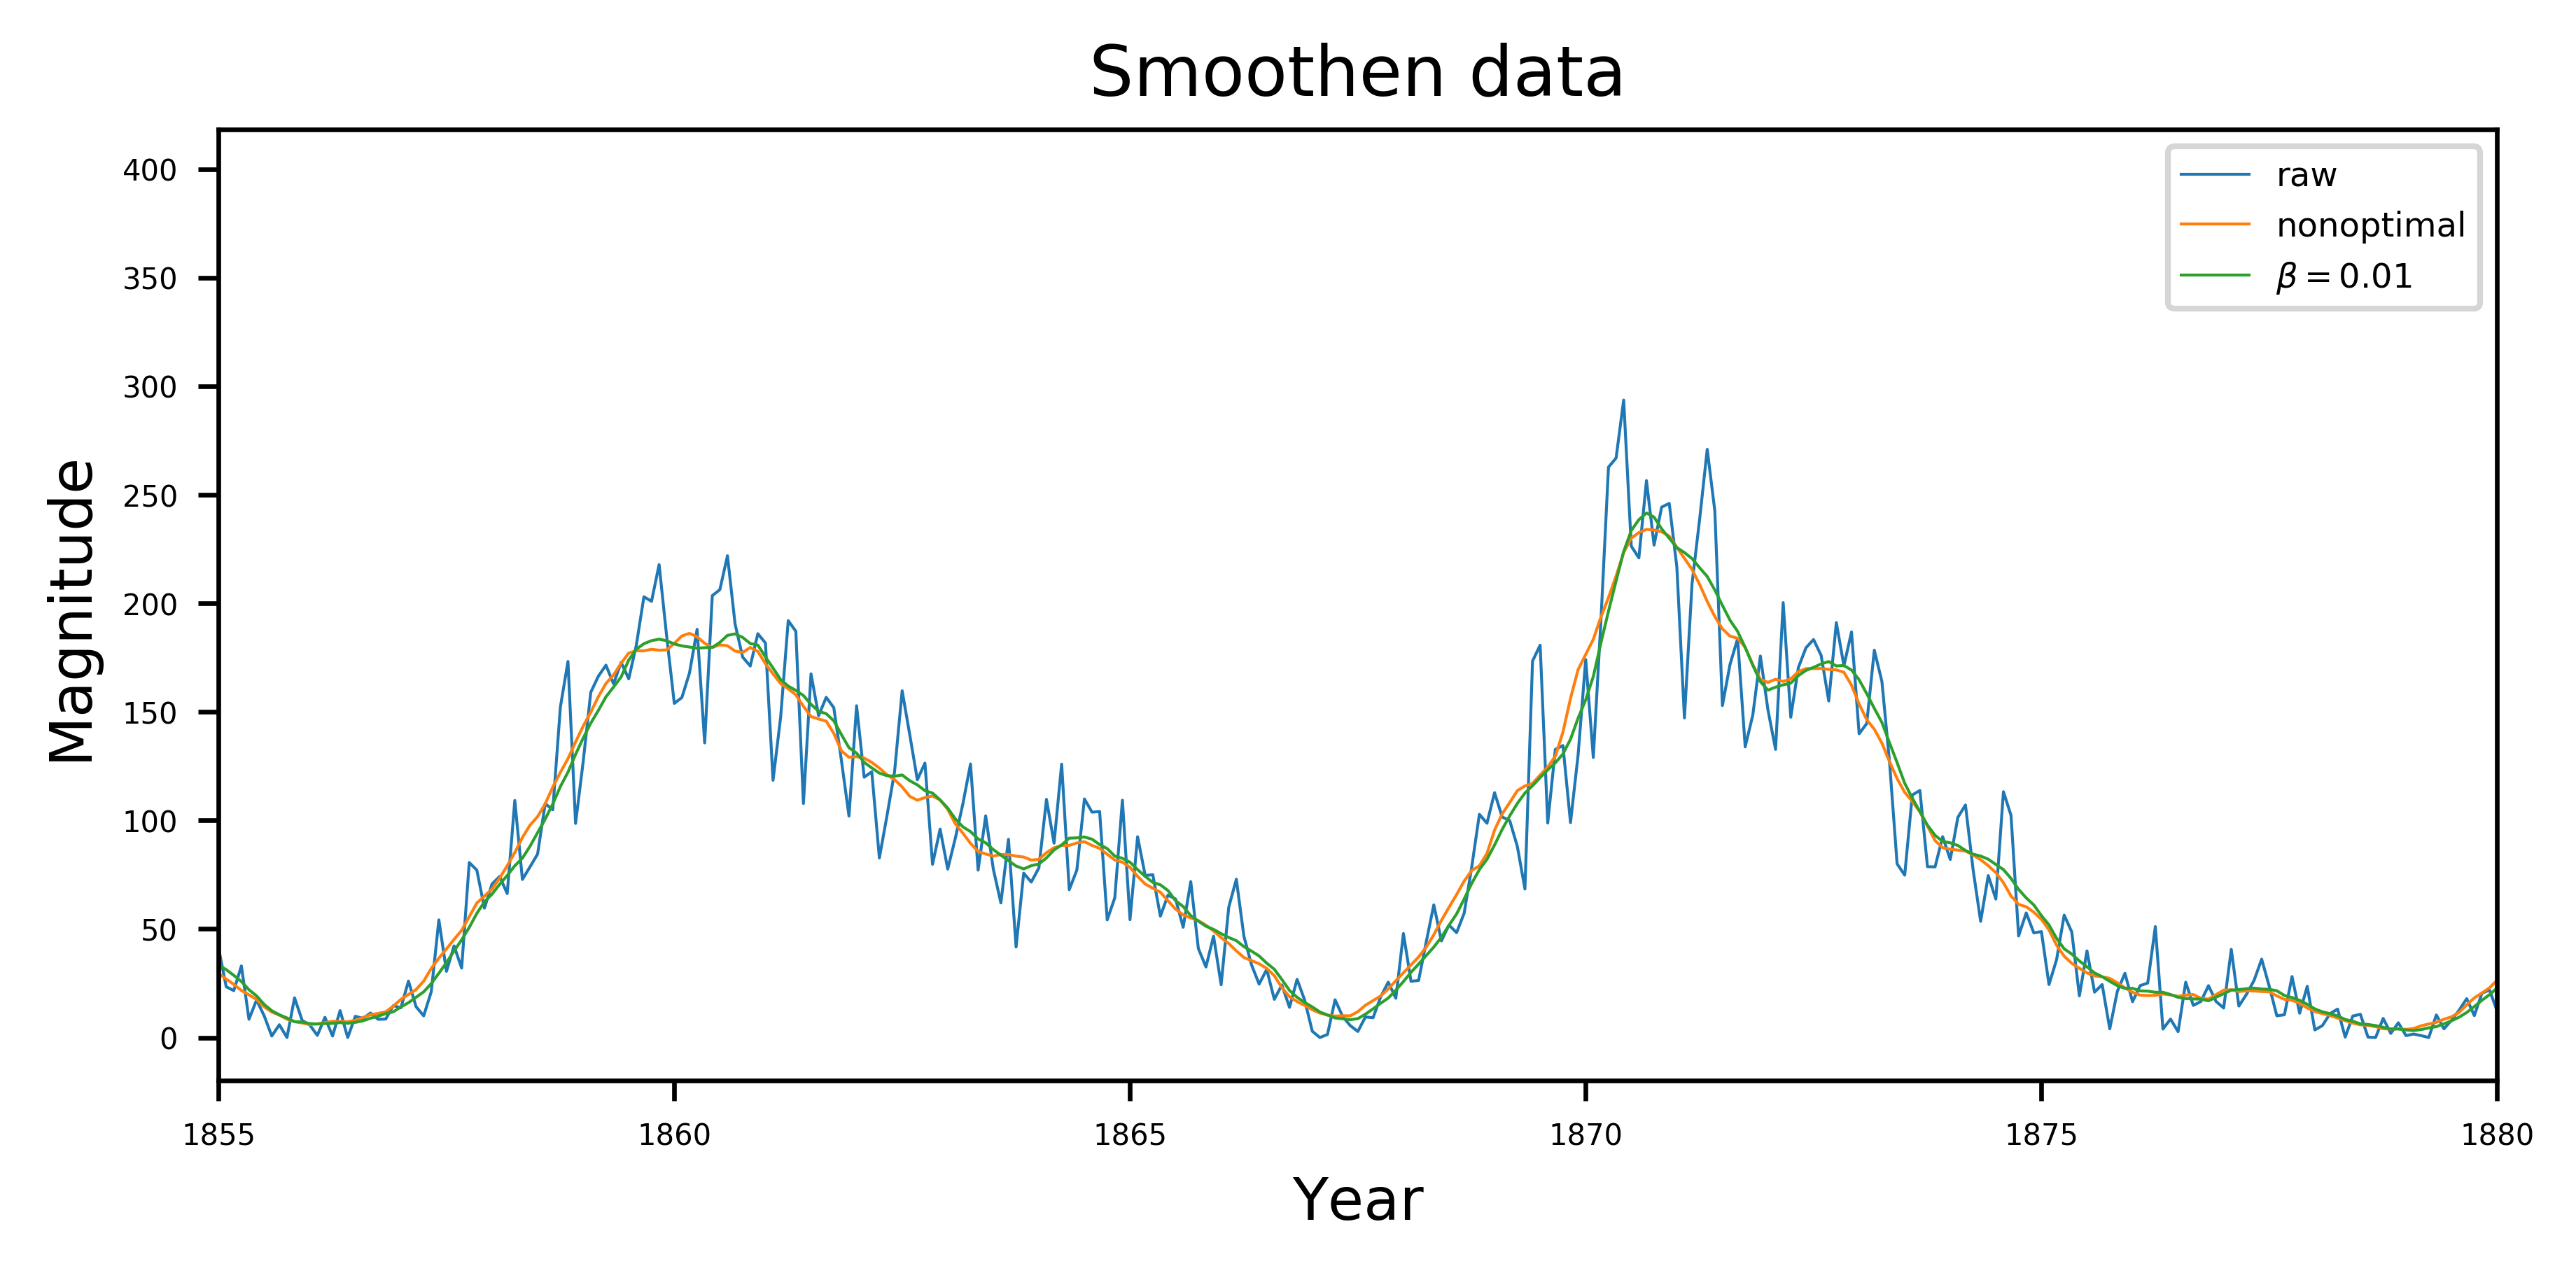

In [112]:
fig, ax = plt.subplots(1,1, figsize=(7,3), dpi = 600)
ax.set_title('Smoothen data')
beta = 0.01
ax.plot((year + month/12), monthly_number, label='raw', linewidth=0.5)
ax.plot((year + month/12), running_mean(monthly_number,13, nonopt_mask[0]), label = 'nonoptimal', linewidth=0.5)
ax.plot((year + month/12), running_mean_A(monthly_number,13, beta), label = r'$\beta = %.2f$'%(beta), linewidth=0.5)
fontP = FontProperties()
fontP.set_size('xx-small')
ax.legend(prop = fontP, loc = 'upper right')
ax.set_xlabel('Year')
ax.set_xlim([1855, 1880])
ax.set_ylabel('Magnitude');

## 13-month opt r-mean still produces some inverse oscillations $-$ check out ~1860 year. That can happen for very thin peaks

# Choose better smoothing 

In [115]:
def Id(z, x):
    return np.sum((z-x)**2)

def Iv(x):
    return np.sum((np.roll(x,-2) - 2 * np.roll(x,-1) + x)[:-2]**2)
def J(z,x, beta):
    return beta*Id(z,x) + Iv(x)

In [123]:
def res(beta):
    return monthly_number, running_mean_A(monthly_number,13, beta)

In [149]:
beta_list = np.linspace(0.001, 0.2, 100)

In [150]:
Id_list = [Id(*res(b)) for b in beta_list]
Iv_list = [Iv(res(b)[1]) for b in beta_list]

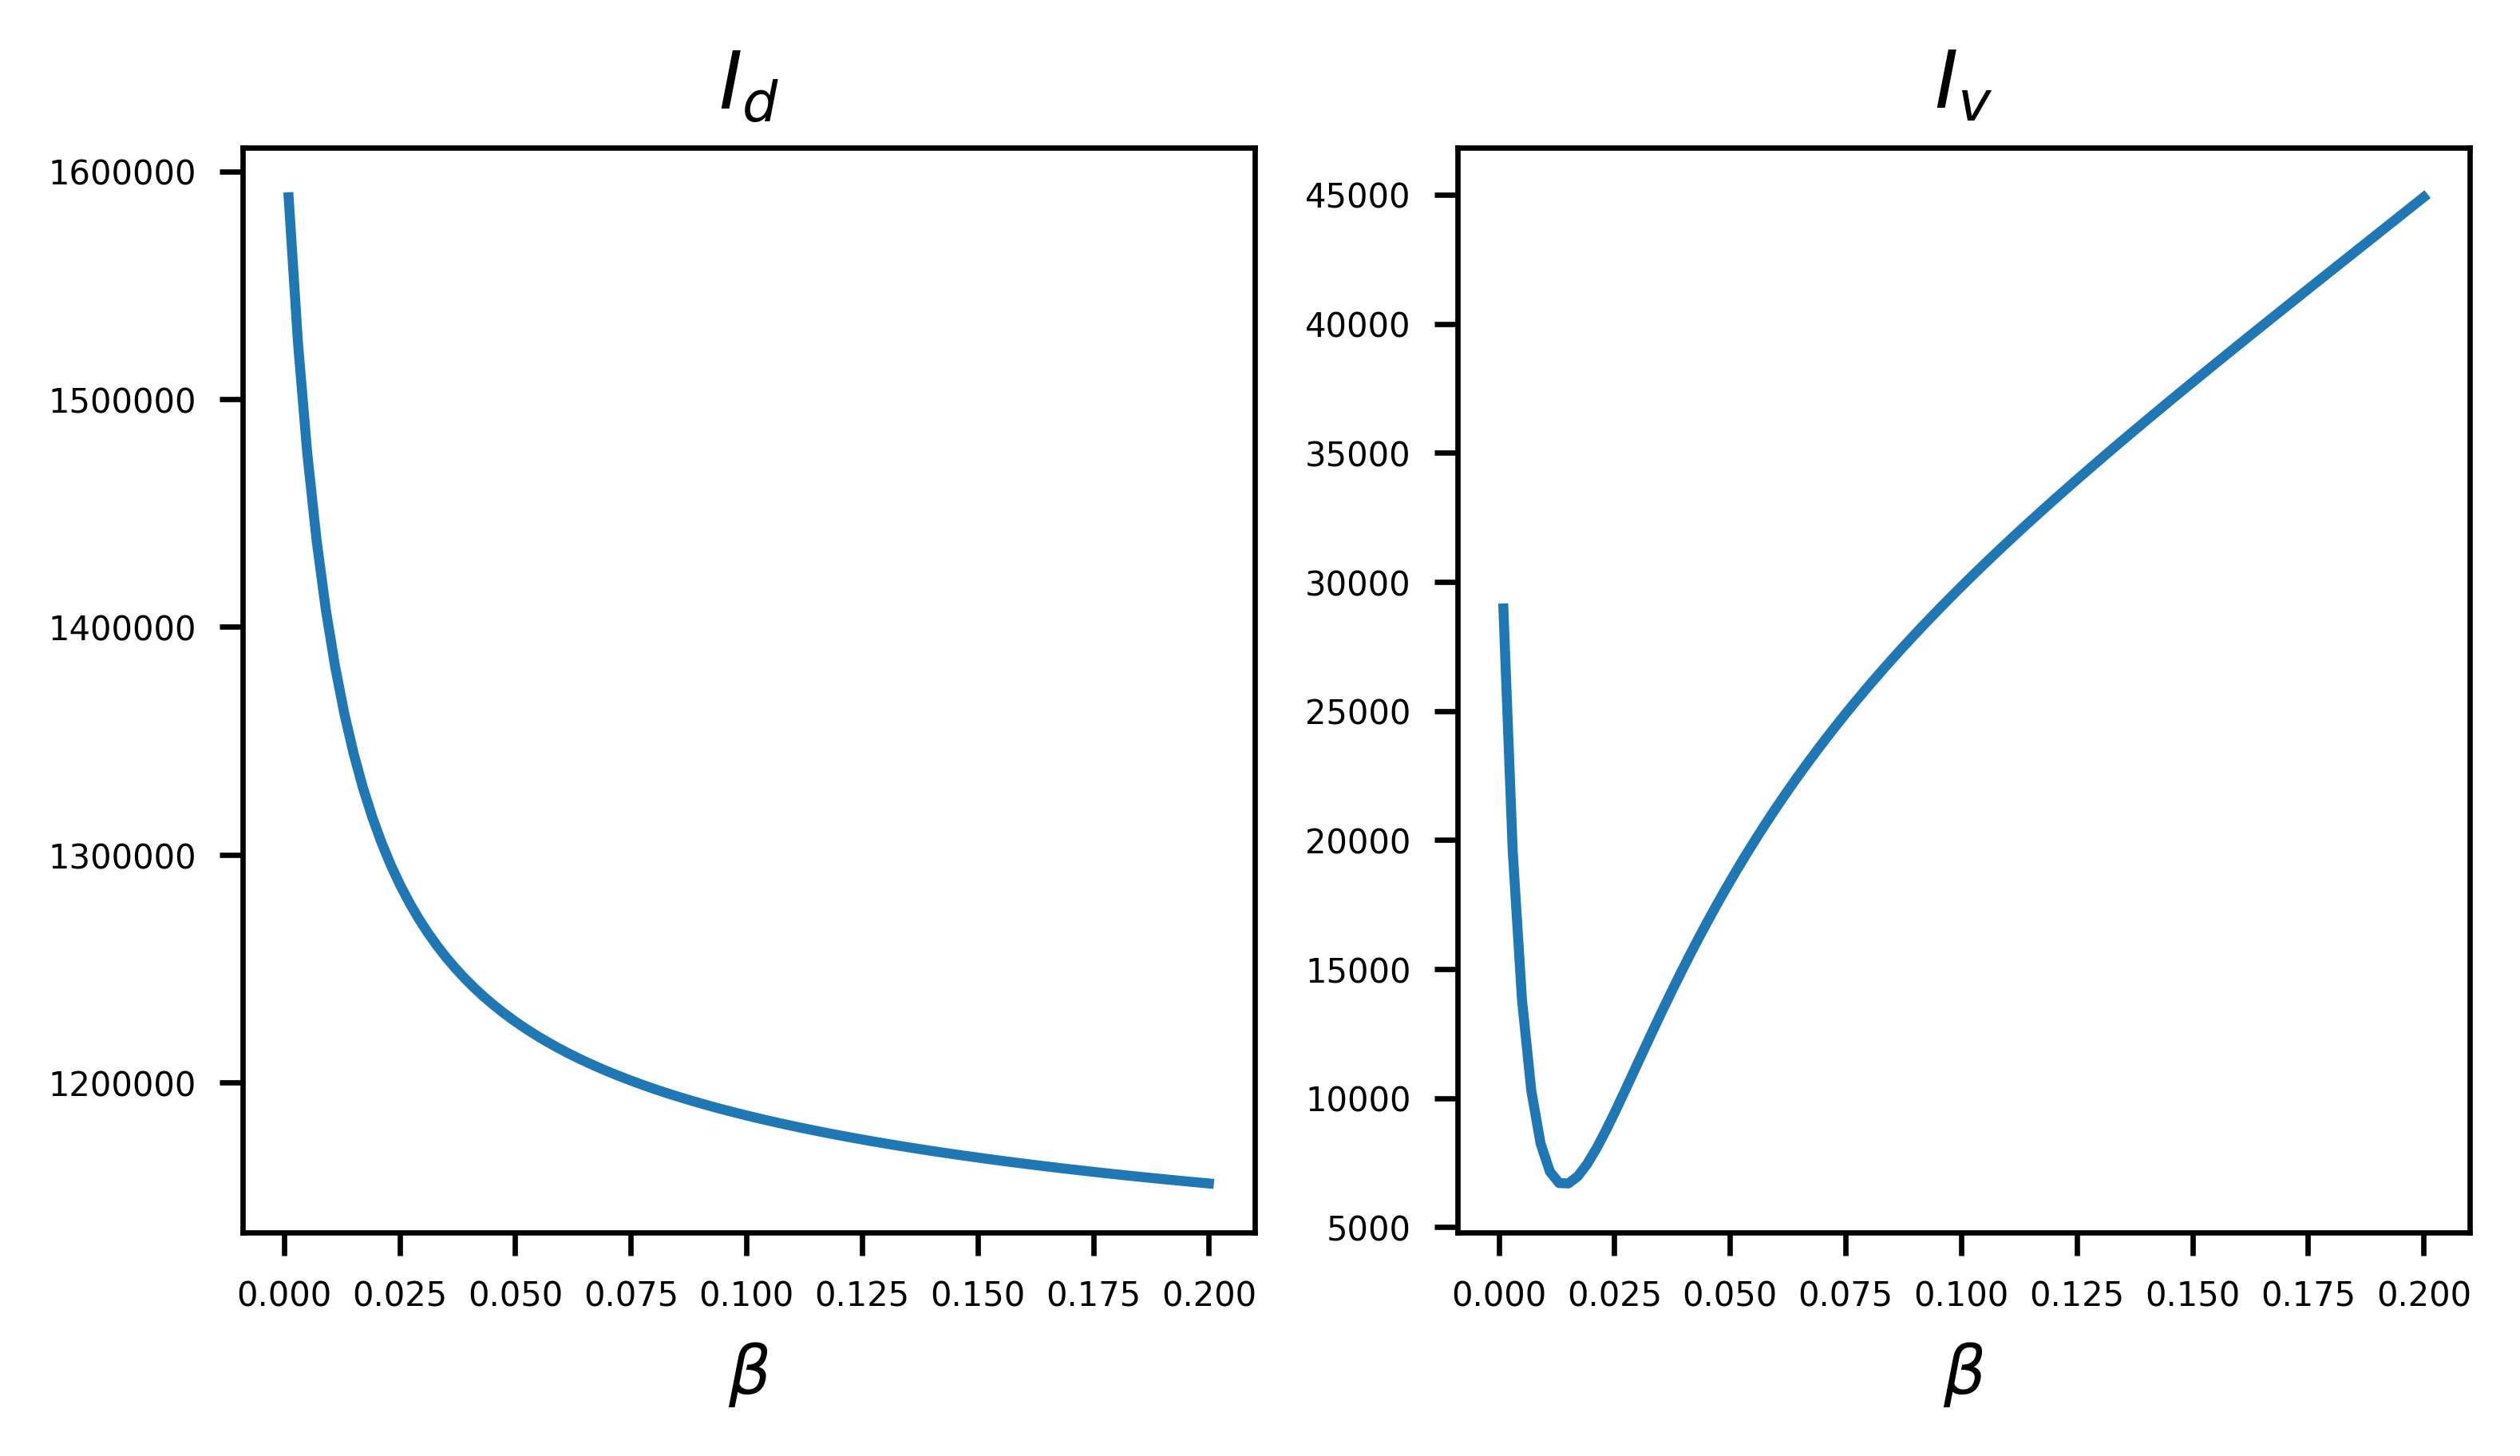

In [164]:
fig, ax = plt.subplots(1,2, figsize=(6,3), dpi=600)
ax[0].plot(beta_list, Id_list)
ax[0].set_title('$I_d$')
ax[0].set_xlabel(r'$\beta$')
ax[1].plot(beta_list, Iv_list)
ax[1].set_title('$I_v$')
ax[1].set_xlabel(r'$\beta$')

# That's up to us, so let's choose Iv-optimal beta

In [157]:
beta_optIv = beta_list[np.argmin([Iv(res(b)[1]) for b in beta_list])]

In [161]:
print("%.3f"%(beta_optIv))

0.015


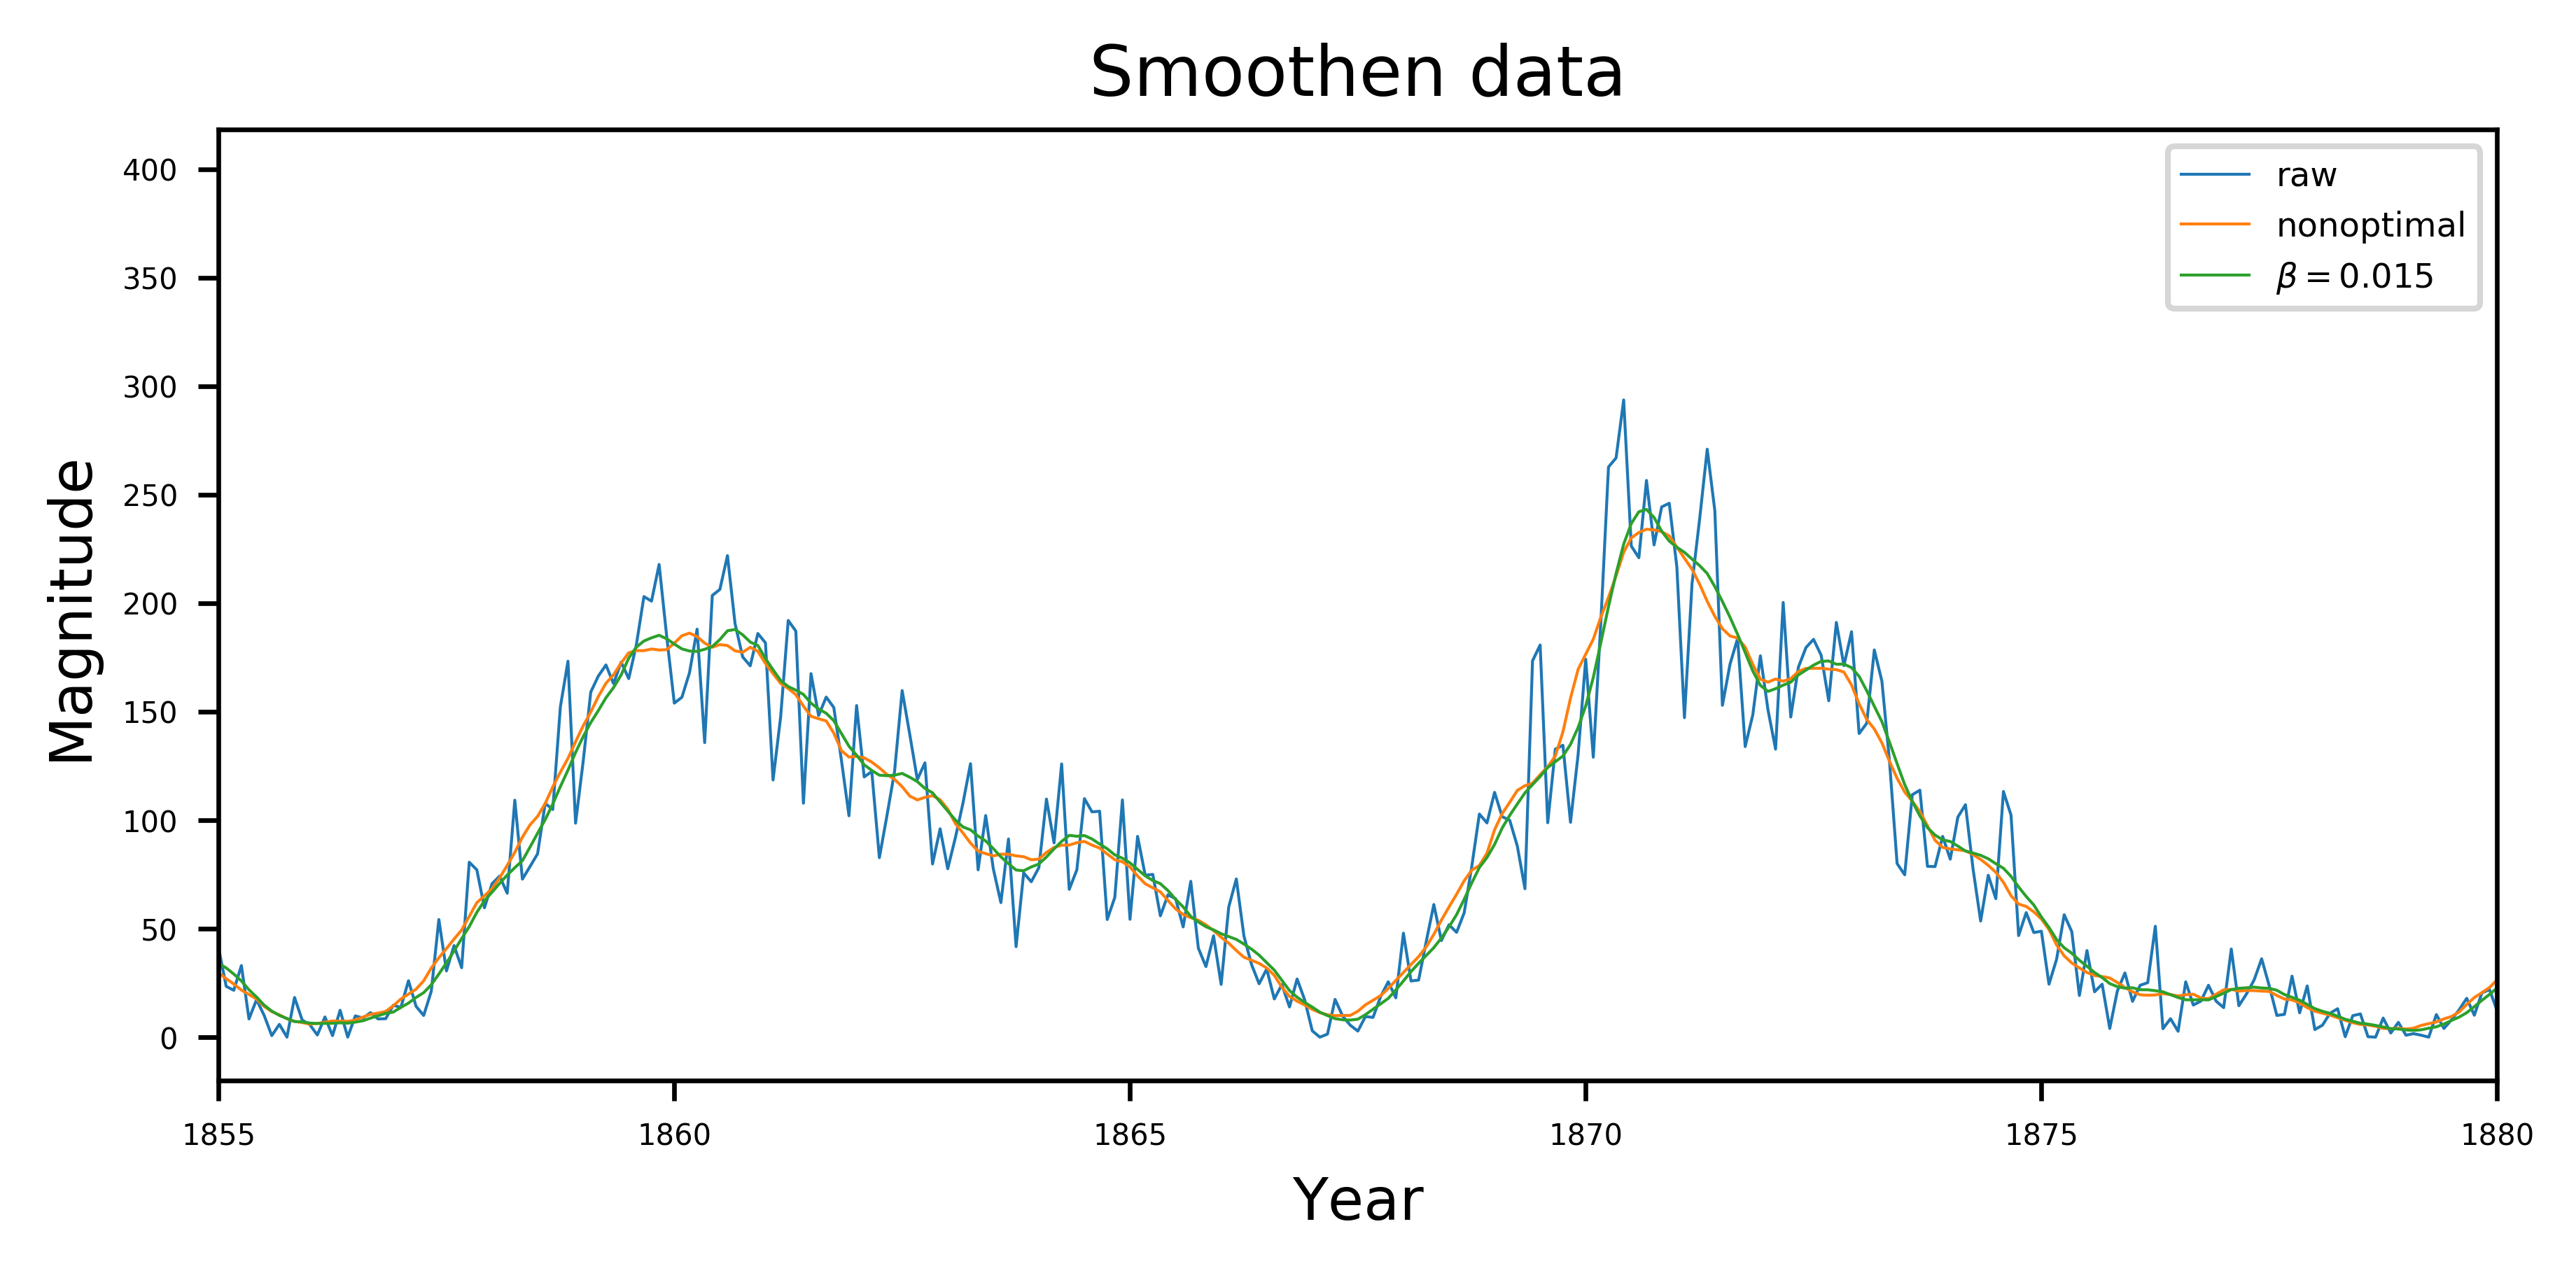

In [163]:
fig, ax = plt.subplots(1,1, figsize=(7,3), dpi = 600)
ax.set_title('Smoothen data')
beta = beta_optIv
ax.plot((year + month/12), monthly_number, label='raw', linewidth=0.5)
ax.plot((year + month/12), running_mean(monthly_number,13, nonopt_mask[0]), label = 'nonoptimal', linewidth=0.5)
ax.plot((year + month/12), running_mean_A(monthly_number,13, beta), label = r'$\beta = %.3f$'%(beta), linewidth=0.5)
fontP = FontProperties()
fontP.set_size('xx-small')
ax.legend(prop = fontP, loc = 'upper right')
ax.set_xlabel('Year')
ax.set_xlim([1855, 1880])
ax.set_ylabel('Magnitude');

# Today we learned how to create optimal running mean filter